In [1]:
#!python -m pip install torch
import torch
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
#!python -m pip install tensorflow
import auto_encoder
import math
import bisect
import pickle
import copy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def seed(num_samples):
    pts = []
    i = 0
    it1 = int(math.sqrt(num_samples)/10)
    it2 = int((num_samples/10) - math.sqrt(num_samples))
    for j in range (10):
        for k in range(10):
            pts.append(i)
            i+=it1
        i+=it2
    return pts

In [3]:
def seq_to_magnetization(arr_seq, num_qubits):
    
    mag_vec = []
    for elem in arr_seq:
        magnetization = 0
        for char in elem:
            temp = (int(char)*-2)+1
            magnetization += temp 
        mag_vec.append(magnetization)
    mag_vec = np.array(mag_vec)
    mag_vec = mag_vec / (num_qubits)
    return mag_vec   

def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp 

In [4]:
def error_points(predicted, truth, num):
    diffs = abs((predicted) - (truth))/(truth)
    points = (-np.asarray(diffs)).argsort()[:num]
    return points

In [5]:
def error_data(mag, mag_t):
    return abs((mag+1) - (mag_t+1))/(mag_t+1)

In [6]:
def print_points(data1, qubits, error_points):    
    data = np.load(data1)
    Bx = data['fields'].T[qubits]
    Bz = data['fields'].T[2*qubits]
    points = []
    for i in error_points:
        points.append((Bx[i],Bz[i]))
    print(points)

In [7]:
def expand_pool(old_pool, error_points, max_pool_size):
    for i in error_points:
        num = int(i)
        if(i not in old_pool):
            bisect.insort(old_pool,i)
        else:
            Bz_low_num = num-1
            Bz_high_num= num+1
            Bz_low_flag=True
            Bz_high_flag=True
            
            Bx_low_num = int(num-math.sqrt(max_pool_size))
            Bx_high_num= int(num+math.sqrt(max_pool_size))
            Bx_low_flag=True
            Bx_high_flag=True
            
            while(Bz_low_flag or Bz_high_flag or Bx_low_flag or Bx_high_flag):
                if(Bz_low_flag):
                    if(Bz_low_num<=0 or Bz_low_num % math.sqrt(max_pool_size)==math.sqrt(max_pool_size)-1):
                        Bz_low_flag=False
                    elif(Bz_low_num not in old_pool):
                        bisect.insort(old_pool,Bz_low_num)
                        Bz_low_flag=False
                    else:
                        Bz_low_num-=1
                if(Bz_high_flag):
                    if(Bz_high_num>=max_pool_size or Bz_high_num % math.sqrt(max_pool_size)==0):
                        Bz_high_flag=False
                    elif(Bz_high_num not in old_pool):
                        bisect.insort(old_pool, Bz_high_num)
                        Bz_high_flag=False
                    else:
                        Bz_high_num+=1
                if(Bx_low_flag):
                    if(Bx_low_num<=0):
                        Bx_low_flag=False
                    elif(Bx_low_num not in old_pool):
                        bisect.insort(old_pool, Bx_low_num)
                        Bx_low_flag=False
                    else:
                        Bx_low_num-=int(math.sqrt(max_pool_size))
                if(Bx_high_flag):
                    if(Bx_high_num>=max_pool_size or Bx_high_num % math.sqrt(max_pool_size)==0):
                        Bx_high_flag=False
                    elif(Bx_high_num not in old_pool):
                        bisect.insort(old_pool, Bx_high_num)
                        Bx_high_flag=False
                    else:
                        Bx_high_num+=int(math.sqrt(max_pool_size))    
                    
    return old_pool

In [9]:
get_dataset = auto_encoder.get_dataset
data_2 = '2_qubit_crit_data.npz'
data_4 = '4_qubit_crit_data.npz'
data_6 = '6_qubit_crit_data.npz'
data_7 = '7_qubit_crit_data.npz'
data_8 = '8_qubit_crit_data.npz'
# data_9 = '9_qubit_crit_data.npz'

training_n_sizes = [2,4,7]
validation_n_sizes = [6,8]

pool_size = 2500

pts = seed(pool_size)

stop = 1

error_p = []

magnetization_6 = []
wave_func_6 = []

In [11]:
for learning_set in range (stop):

    training_data_2 = auto_encoder.get_dataset_active(data_2,2,pool_size, pts)
    training_data_4 = auto_encoder.get_dataset_active(data_4,4,pool_size, pts)
    training_data_7 = auto_encoder.get_dataset_active(data_7,7,pool_size, pts) 


    split1 = int(len(pts)*0.9)
    split2 = int(len(pts)/10)
    split1 += len(pts)-(split1+split2)
    
    training_data_2, val_data_2 = random_split(training_data_2, [split1,split2])
    training_data_4, val_data_4 = random_split(training_data_4, [split1,split2])
    training_data_7, val_data_7 = random_split(training_data_7, [split1,split2])

    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=20) for x in datasets]

    val_data_6 = get_dataset(data_6, 6, pool_size)
    val_data_8 = get_dataset(data_8, 8, pool_size)
#     val_data_9 = get_dataset(data_9, 9, pool_size)

    val_datasets = [val_data_6, val_data_8, val_data_2, val_data_4, val_data_7] # val_data_9

    val_loaders = [DataLoader(x, batch_size = 10, num_workers=20) for x in val_datasets]

    warmup_2 = next(iter(training_loaders[0]))
    warmup_4 = next(iter(training_loaders[1]))
    warmup_7 = next(iter(training_loaders[2]))

    mps_size = 5
    model = auto_encoder.MPS_autoencoder(mps_size = mps_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_func = nn.MSELoss(reduction='sum')

    warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

    print("WARMUP TRAINING ITERATION: ", learning_set)
    for j in range(10):
        for i in range(3):
            for epoch in range(10):
                fields,wf = warmup_data[i][0]
                gs = model(fields, warmup_data[i][1])            
                loss = loss_func(gs, wf)
                if (epoch % 10 == 0):
                    current_loss = loss.item() *(2**warmup_data[i][1])
                    print(warmup_data[i][1],"\t", current_loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    print("__________________________________________________")
    print()

    print("Training Validation ", learning_set)
    val_6 = next(iter(val_loaders[0]))
    val_8 = next(iter(val_loaders[1]))
    #val_9 = next(iter(val_loaders[2]))
    val_2 = next(iter(val_loaders[2]))
    val_4 = next(iter(val_loaders[3]))
    val_7 = next(iter(val_loaders[4]))
    
    
    train_sizes = [2,4,7]
    val_sizes = [6,8,2,4,7]
    model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      


WARMUP TRAINING ITERATION:  0
2 	 91.46992492675781
4 	 171.60174560546875
7 	 14156.5224609375
2 	 7.224798202514648
4 	 123.68515014648438
7 	 1273.8349609375
2 	 8.406875610351562
4 	 54.453163146972656
7 	 430.57122802734375
2 	 5.372180938720703
4 	 51.13019561767578
7 	 447.0288391113281
2 	 3.8618950843811035
4 	 37.66184997558594
7 	 206.40982055664062
2 	 3.6134824752807617
4 	 39.37448501586914
7 	 309.2002258300781
2 	 3.410351037979126
4 	 28.451642990112305
7 	 111.21783447265625
2 	 2.2019290924072266
4 	 48.410213470458984
7 	 317.1532897949219
2 	 1.1467351913452148
4 	 20.075458526611328
7 	 306.92657470703125
2 	 1.4505658149719238
4 	 32.48045349121094
7 	 98.90509796142578
__________________________________________________

Training Validation  0


ValueError: too many values to unpack (expected 2)

In [12]:
print("Training Validation ", learning_set)
val_6 = next(iter(val_loaders[0]))
val_8 = next(iter(val_loaders[1]))
#val_9 = next(iter(val_loaders[2]))
val_2 = next(iter(val_loaders[2]))
val_4 = next(iter(val_loaders[3]))
val_7 = next(iter(val_loaders[4]))


train_sizes = [2,4,7]
val_sizes = [6,8,2,4,7]
model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      

Training Validation  0
Epoch 2 : 	 Training_Error: 0.47812 	 Val Error: 0.46336
********************************************************************************
2_qubit_loss: 0.08443 	 	 |4_qubit_loss: 0.13146 	 	 |7_qubit_loss: 0.26222 	 	 |
********************************************************************************
6_qubit_loss: 0.09533 	 	 |8_qubit_loss: 0.12520 	 	 |2_qubit_loss: 0.06853 	 	 |4_qubit_loss: 0.10949 	 	 |7_qubit_loss: 0.06481 	 	 |



Epoch 4 : 	 Training_Error: 0.34191 	 Val Error: 0.43756
********************************************************************************
2_qubit_loss: 0.06532 	 	 |4_qubit_loss: 0.07642 	 	 |7_qubit_loss: 0.20018 	 	 |
********************************************************************************
6_qubit_loss: 0.08884 	 	 |8_qubit_loss: 0.12095 	 	 |2_qubit_loss: 0.05947 	 	 |4_qubit_loss: 0.09978 	 	 |7_qubit_loss: 0.06853 	 	 |



Epoch 6 : 	 Training_Error: 0.31040 	 Val Error: 0.37354
****************************************

In [16]:
print("TRAINING ITERATION: ", learning_set)
for j in range(10):
    print("Cycle: \t", j)
    print("*"*40)
    for i in range(3):
        for epoch in range(201):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 100 == 0):
                current_loss = loss.item() *(2**warmup_data[i][1])
                print(warmup_data[i][1],"\t", current_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if(j==9):
            final_training_epoch_loss[learning_set][i] = current_loss
print("__________________________________________________")
print()

warmup_2 = next(iter(training_loaders[0]))
warmup_4 = next(iter(training_loaders[1]))
warmup_7 = next(iter(training_loaders[2]))
warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

q2=[]
q4=[]
q7=[]
rolling_loss=[q2,q4,q7]
converged = [False,False,False]

print("TRAINING LOSS ITERATION: ", learning_set)
while(not converged[0] or not converged[1] or not converged[2]):
    for i in range(3):
        if(not converged[i]):
            for epoch in range(10):
                fields,wf = warmup_data[i][0]
                gs = model(fields, warmup_data[i][1])            
                loss = loss_func(gs, wf)
                if (epoch % 10 == 0):
                    current_loss = loss.item() *(2**warmup_data[i][1])
                    print(warmup_data[i][1],"\t", current_loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                rolling_loss[i].append(current_loss)
            if(auto_encoder.check_converged(rolling_loss[i],current_loss)):
                converged[i] = True
            if(j==9):
                final_training_loss[learning_set][i] = current_loss        
print("__________________________________________________")
print()

warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]
f = open("warmup_data_2.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

f = open("warmup_data_1.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

val_6 = next(iter(val_loaders[0]))
#val_8 = next(iter(val_loaders[1]))
#val_9 = next(iter(val_loaders[2]))
val_2 = next(iter(val_loaders[1]))
val_4 = next(iter(val_loaders[2]))
val_7 = next(iter(val_loaders[3]))

print("VALIDATION LOSS ITERATION: ", learning_set)
val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
#val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
loss_func = nn.MSELoss()
count=0
for data, size in val_data:
    with torch.no_grad():
        fields, wf = data
        gs = model(fields, size)
        loss = loss_func(gs,wf)
        current = loss.item() * (2**size)
        print(size,"\t" ,current)

print("__________________________________________________")
print()


TRAINING LOSS ITERATION:  0
2 	 0.0024403519928455353
4 	 0.0033827587030828
7 	 0.04768058657646179
2 	 0.002258509397506714
4 	 0.004823268391191959
7 	 0.04935653507709503
2 	 0.0019470334518700838
7 	 0.039856452494859695
2 	 0.0013789518270641565
7 	 0.027227871119976044
2 	 0.0012946446659043431
7 	 0.022766955196857452
2 	 0.0011837121564894915
7 	 0.022192830219864845
2 	 0.0010954298777505755
7 	 0.021468626335263252
2 	 0.0010349832009524107
7 	 0.020602300763130188
2 	 0.0009828751208260655
7 	 0.020057959482073784
2 	 0.0009233261225745082
7 	 0.019508007913827896
2 	 0.0008775846799835563
7 	 0.01877898909151554
2 	 0.0008373594610020518
7 	 0.018056856468319893
2 	 0.0007986766286194324
7 	 0.01732061058282852
2 	 0.0007594624767079949
7 	 0.016657888889312744
2 	 0.0007228058530017734
7 	 0.016047386452555656
2 	 0.0006865583709441125
7 	 0.015371917746961117
2 	 0.0006545317592099309
7 	 0.014651447534561157
2 	 0.0006219153292477131
7 	 0.0140533447265625
2 	 0.0005913

KeyboardInterrupt: 

In [26]:
print("VALIDATION LOSS ITERATION: ", learning_set)
val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
#val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
loss_func = nn.MSELoss()
count=0
for data, size in val_data:
    with torch.no_grad():
        fields, wf = data
        gs = model(fields, size)
        loss = loss_func(gs,wf)
        current = loss.item() * (2**size)
        print(size,"\t" ,current)

print("__________________________________________________")
print()

f = open("test_data_1.p", 'wb')
pickle.dump(val_data, f)

device = torch.device("cpu")
for N, train_loader in enumerate(training_loaders):            
    temp = 0
    sys_size = training_n_sizes[N]
    for i, (fields,wf) in enumerate(train_loader):
        fields = fields.to(device)
        gs = model(fields, sys_size)            
        loss = loss_func(gs, wf.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp += loss.item()
    temp = temp / (len(train_loader)) 

data_sizes = [2,4,6,7,8]#,9]
training_data_2 = get_dataset(data_2, 2, pool_size)
training_data_4 = get_dataset(data_4,4,pool_size)
training_data_7 = get_dataset(data_7,7,pool_size) 
val_data_6 = get_dataset(data_6, 6, pool_size)
val_data_8 = get_dataset(data_8, 8, pool_size)
#val_data_9 = get_dataset(data_9, 9, pool_size)
mag_dat = [training_data_2,training_data_4,val_data_6,training_data_7, val_data_8]#, val_data_9]
mag_loaders = [DataLoader(x, batch_size = len(val_data_6), num_workers=20) for x in mag_dat]

model.eval()
with torch.no_grad():
    n_systems = {}
    for j,loader in enumerate((mag_loaders)):
        sys_size = data_sizes[j]
        wave_functions = []
        true_wave = []
        for i, (fields,wf) in enumerate(loader):
            fields = fields
            gs = model(fields, sys_size)

            wave_functions.append(gs)
            true_wave.append(wf)

        n_systems[sys_size] = (wave_functions,true_wave)


#     data_y_2 = n_systems[2][0][0].numpy()
#     data_y_4 = n_systems[4][0][0].numpy()
#     data_y_7 = n_systems[7][0][0].numpy()
data_y_6 = n_systems[6][0][0].numpy()
#     data_y_8 = n_systems[8][0][0].numpy()
#     data_y_9 = n_systems[9][0][0].numpy()


#     print(data_y_2.shape)
#     data_y_2_t = n_systems[2][1][0].numpy()
#     data_y_4_t = n_systems[4][1][0].numpy()
#     data_y_7_t = n_systems[7][1][0].numpy()
data_y_6_t = n_systems[6][1][0].numpy()
#     data_y_8_t = n_systems[8][1][0].numpy()
#     data_y_9_t = n_systems[9][1][0].numpy()

#     vec = seq_to_magnetization(seq_gen(2),2)
#     vec_2 = (vec.view()).reshape((4,1))
#     mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
#     mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

#     vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
#     mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
#     mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))

vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))

magnetization_6.append(mag_6)

#     vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
#     mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
#     mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

#     vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
#     mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
#     mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

#     vec_9 = seq_to_magnetization(seq_gen(9),9).reshape((512,1))
#     mag_9 = np.squeeze((np.power(data_y_9,2) @ vec_9))
#     mag_9_t = np.squeeze((np.power(data_y_9_t,2) @ vec_9))

error_pts = error_points(data_y_6[0], data_y_6_t[0], 5)
print("ERROR POINTS:")
print_points(data_6, 6, error_pts)

error_p.append(error_data(data_y_6[0],data_y_6_t[0]))

pts = expand_pool(pts, error_pts, pool_size)
print("NEW SET: ")
print(pts)
print()
print("_________________________________")

VALIDATION LOSS ITERATION:  0
6 	 0.018769163638353348
8 	 0.03209934011101723
2 	 0.013503698632121086
4 	 0.015318724326789379
7 	 0.014337776228785515
__________________________________________________

ERROR POINTS:
[(0.0, 1.2689795918367348), (0.0, 1.3908163265306124), (0.0, 1.4314285714285715), (0.0, 1.4720408163265306), (0.0, 1.51265306122449)]
NEW SET: 
[0, 5, 10, 15, 20, 25, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 45, 85, 86, 87, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1500, 1505, 1510, 1515, 1520, 1525, 1530, 1535, 1540, 1545, 1750, 1755, 1760, 1765, 1770, 1775, 1780, 1785, 1790, 1795, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2250, 2255, 2260, 2265, 2270, 2275, 2280, 2285, 2290, 2295]

_________________________________


<ipython-input-4-dcf06fac18d4>:2: RuntimeWarning: divide by zero encountered in true_divide
  diffs = abs((predicted) - (truth))/(truth)


In [24]:
print(error_points(data_y_6[30], data_y_6_t[30],5))
print(error_points(mag_6, mag_6_t, 5))
print(np.shape(data_y_6))
print(np.shape(mag_6))


[31 34 35 36 37]
[2450 2400 2350 2300 2250]
(2500, 64)
(2500,)


<ipython-input-4-dcf06fac18d4>:2: RuntimeWarning: divide by zero encountered in true_divide
  diffs = abs((predicted) - (truth))/(truth)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


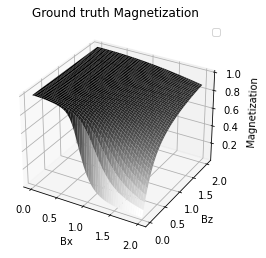

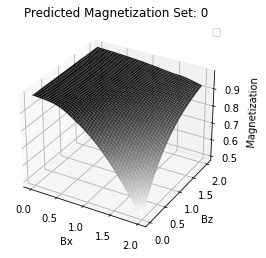

In [27]:
data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

x = np.reshape(Bx, (50, 50))
y = np.reshape(Bz, (50, 50))
z = np.reshape(mag_6_t, (50, 50))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

for i in range (stop):
    z = np.reshape(magnetization_6[i], (50, 50))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bx")
    ax.set_ylabel("Bz")
    ax.set_zlabel("Magnetization")

    

No handles with labels found to put in legend.
No handles with labels found to put in legend.


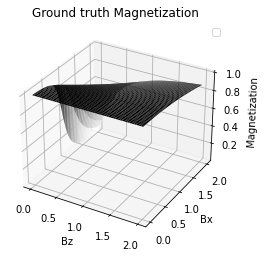

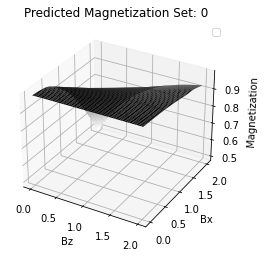

In [28]:
y = np.reshape(Bx, (50, 50))
x = np.reshape(Bz, (50, 50))
z = np.reshape(mag_6_t, (50, 50))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization")
ax.set_xlabel("Bz")
ax.set_ylabel("Bx")
ax.set_zlabel("Magnetization")

for i in range (stop):
    z = np.reshape(magnetization_6[i], (50, 50))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bz")
    ax.set_ylabel("Bx")
    ax.set_zlabel("Magnetization")

[0.99330064 0.99336959 0.99343388 ... 0.92288217 0.92529364 0.92760598]
[[9.9032998e-01 5.5441700e-02 5.5441692e-02 9.0649342e-03 5.5441696e-02
  6.1883875e-03 9.0649351e-03 2.1648454e-03 5.5441696e-02 3.5582553e-03
  6.1883866e-03 1.1411738e-03 9.0649351e-03 5.1614980e-04 2.1648451e-03
  6.0229457e-04 5.5441696e-02 6.1883871e-03 3.5582555e-03 5.1614991e-04
  6.1883866e-03 1.0587905e-03 1.1411739e-03 4.4843700e-04 9.0649342e-03
  1.1411736e-03 5.1614974e-04 8.4470223e-05 2.1648449e-03 4.4843694e-04
  6.0229463e-04 2.4296208e-04 5.5441700e-02 9.0649370e-03 6.1883871e-03
  2.1648451e-03 3.5582555e-03 1.1411738e-03 5.1614980e-04 6.0229469e-04
  6.1883861e-03 5.1614980e-04 1.0587905e-03 4.4843697e-04 1.1411735e-03
  8.4470194e-05 4.4843691e-04 2.4296209e-04 9.0649361e-03 2.1648449e-03
  1.1411738e-03 6.0229457e-04 5.1614968e-04 4.4843694e-04 8.4470230e-05
  2.4296211e-04 2.1648451e-03 6.0229475e-04 4.4843697e-04 2.4296209e-04
  6.0229463e-04 2.4296214e-04 2.4296214e-04 4.3852968e-04]]
(3,)

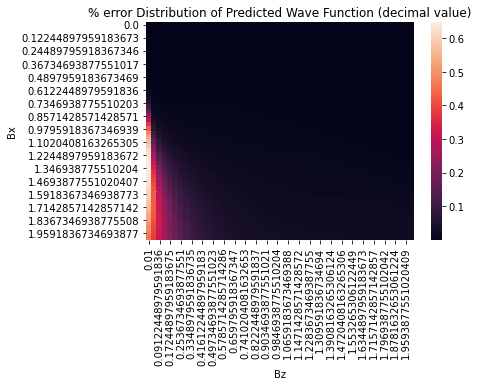

In [37]:
import pandas as pd
import seaborn as sns

data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

pp=[]
pp.append(error_data(mag_6,mag_6_t))

print(mag_6)
print(data_y_6[0].))
print(np.shape(error_p))
for i in error_p:
    data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error':i})
    data = data.pivot(index='Bx', columns='Bz', values='% error')
#    plt.hist2d(Bx, By, bins=N_bins, cmap='plasma')
    sns.heatmap(data)

    # Plot a colorbar with label.
#    cb = plt.colorbar()

    # Add title and labels to plot.
    plt.title('% error Distribution of Predicted Wave Function (decimal value)')
#     plt.xlabel('Bx')
#     plt.ylabel('Bz')

    # Show the plot.
    plt.show()